In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

np.random.seed(0)

# 수치미분 함수

def numerical_derivative(f, x):
    delta_x = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x) # f(x+delta_x)
        
        x[idx] = float(tmp_val) - delta_x 
        fx2 = f(x) # f(x-delta_x)
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad

# sigmoid 함수

def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [11]:
class Diabetes:
    def __init__(self, i_node, h_node, o_node, lr):
        self.learning_rate = lr
        
        self.W2 = np.random.rand(i_node, h_node)
        self.b2 = np.random.rand(1)
        
        self.W3 = np.random.rand(h_node, o_node)
        self.b3 = np.random.rand(1)
        
        print("========== Diabetes Object is created. ==========\n")
        
    def feed_forward(self, x_data, t_data):
        delta = 1e-7
        
        z2 = np.dot(self.x_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        a3 = sigmoid(z3)
        
        return -np.sum((self.t_data*np.log10(a3 + delta)) + ((1 - self.t_data)*np.log10((1 - a3) + delta)))

    def loss_val(self):
        delta = 1e-7
        
        z2 = np.dot(self.x_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        a3 = sigmoid(z3)
        
        return -np.sum((self.t_data*np.log10(a3 + delta)) + ((1 - self.t_data)*np.log10((1 - a3) + delta)))
    
    def train(self, x_data, t_data):
        self.x_data = x_data
        self.t_data = t_data
        
        f = lambda x : self.feed_forward(self.x_data, self.t_data)
        
        self.W2 -= self.learning_rate * numerical_derivative(f, self.W2)
        self.b2 -= self.learning_rate * numerical_derivative(f, self.b2)
        self.W3 -= self.learning_rate * numerical_derivative(f, self.W3)
        self.b3 -= self.learning_rate * numerical_derivative(f, self.b3)
        
    def predict(self, test_data):
        z2 = np.dot(test_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        a3 = sigmoid(z3)
        
        if a3 >= 0.5:
            result = 1
        else:
            result = 0
    
        return a3, result
    
    def accuracy(self, test_xdata, test_tdata):
        matched_list = []
        not_matched_list = []
        
        for index in range(len(test_xdata)):
            (real_val, logical_val) = self.predict(test_xdata[index])
            
            if logical_val == test_tdata[index]:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
                
        accuracy_val = len(matched_list) / len(test_xdata)
        
        return accuracy_val
    
    def display_lossval_trend(self, loss_val_list, lr, epoch):
        plt.title('Loss Value Trend')
        plt.xlabel('epochs')
        plt.ylabel('Loss value')
        plt.grid()

        plt.plot(loss_val_list, ls='--', lw=2, label='lr={}, epoch={}'.format(lr, epoch))
        plt.legend(loc='best')

        plt.show()
        
    def training_validation_accuracy_trend(self, training_acc, validation_acc, lr, epoch):
        plt.title('Training / Validation Accuracy Trend')
        plt.xlabel('epochs')
        plt.ylabel('Accuracy')
        plt.grid()

        plt.plot(training_acc, ls='--', label='lr={}, epoch={}'.format(lr, epoch))
        plt.plot(validation_acc, ls='--', label='lr={}, epoch={}'.format(lr, epoch))
        plt.legend(loc='best')

        plt.show()

In [3]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, name, file_path, seperation_rate, target_position=-1):
        
        self.name = name
        
        self.file_path = file_path
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], ', count = ', counts[index])
        
            unique_target.append(unique[index])

        for index in range(len(unique_target)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique_target[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        try:
            loaded_data = np.loadtxt(self.file_path, delimiter=',', dtype=np.float32)
            
        except Exception as err:
            print('[DataGeneration::generate()]  ', str(err))
            raise Exception(str(err))

        print("[DataGeneration] loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

In [4]:
seperation_rate = 0.3
target_position = -1    # 정답은 마지막 열

try:
    data_obj = DataGeneration('Diabetes', './diabetes.csv', seperation_rate, target_position)

    (generated_training_data, generated_test_data) = data_obj.generate()
    
    print("generated_training_data.shape = ", generated_training_data.shape)
    print("generated_test_data.shape = ", generated_test_data.shape)

except Exception as err:
    print('Exception Occur !!')
    print(str(err))

[DataGeneration] loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  180
[DataGeneration] unique number of training data =  1.0 , count =  352
[DataGeneration] unique number of training data =  0.0 , ratio =  33.83  %
[DataGeneration] unique number of training data =  1.0 , ratio =  66.17  %
[DataGeneration] unique number of test data =  0.0 , count =  83
[DataGeneration] unique number of test data =  1.0 , count =  144
[DataGeneration] unique number of test data =  0.0 , ratio =  36.56  %
[DataGeneration] unique number of test data =  1.0 , ratio =  63.44  %
generated_training_data.shape =  (532, 9)
generated_test_data.shape =  (227, 9)


In [15]:
i_node = generated_training_data.shape[1] - 1
h_node = 10
o_node = 1
lr = 1e-1
epoch = 20

obj1 = Diabetes(i_node, h_node, o_node, lr)

print("Neural Network Learning using Numerical Derivative...\n")

#training_validation_accuracy_trend(self, training_acc, validation_acc, lr, epoch):
#accuracy(self, test_xdata, test_tdata

loss_val_list = []
training_acc_list = []
validation_acc_list = []

start_time = datetime.now()

for step in range(epoch):
    for index in range(len(generated_training_data)):
        input_data = generated_training_data[index, 0:-1]
        target_data = generated_training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    if step % (int)(0.05*epoch) == 0:
        cur_loss_val = obj1.loss_val()
        print("=========================================================")
        print("epochs = ", step, " : ", "loss value = ", obj1.loss_val(), '\n')

        training_accuracy = obj1.accuracy(generated_training_data[:, 0:-1], generated_training_data[:, -1])
        validation_accuracy = obj1.accuracy(generated_test_data[:, 0:-1], generated_test_data[:, -1])
        print("epochs = ", step, " : ", "training accuracy = ", training_accuracy)
        print("epochs = ", step, " : ", "validation accuracy = ", validation_accuracy)
        
        loss_val_list.append(cur_loss_val)
        training_acc_list.append(training_accuracy)
        validation_acc_list.append(validation_accuracy)

end_time = datetime.now()

print("=========================================================")
        
print("")
print("Elapsed Time => ", end_time - start_time)

========== Diabetes Object is created. ==========

Neural Network Learning using Numerical Derivative...

epochs =  0  :  loss value =  0.4016513784303445 

epochs =  0  :  training accuracy =  0.6560150375939849
epochs =  0  :  validation accuracy =  0.6343612334801763
epochs =  1  :  loss value =  0.39061591614578817 

epochs =  1  :  training accuracy =  0.7030075187969925
epochs =  1  :  validation accuracy =  0.7268722466960352
epochs =  2  :  loss value =  0.37753960469532594 

epochs =  2  :  training accuracy =  0.7218045112781954
epochs =  2  :  validation accuracy =  0.7577092511013216
epochs =  3  :  loss value =  0.3641131454953693 

epochs =  3  :  training accuracy =  0.7556390977443609
epochs =  3  :  validation accuracy =  0.762114537444934
epochs =  4  :  loss value =  0.35168632313076115 

epochs =  4  :  training accuracy =  0.7537593984962406
epochs =  4  :  validation accuracy =  0.7709251101321586
epochs =  5  :  loss value =  0.340109897482298 

epochs =  5  :  t

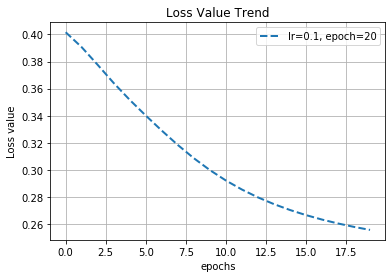

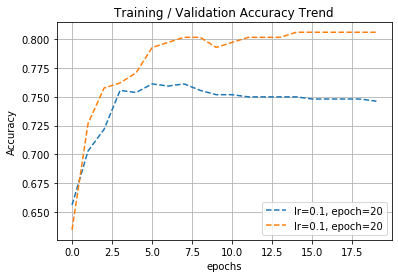

In [16]:
obj1.display_lossval_trend(loss_val_list, lr, epoch)
obj1.training_validation_accuracy_trend(training_acc_list, validation_acc_list, lr, epoch)

In [17]:
try:
    input_data = generated_test_data[:, 0:-1]
    target_data = generated_test_data[:, [-1]]

    accuracy_ret = obj1.accuracy(input_data, target_data)
    
    print('Accuracy => ', accuracy_ret)
    
except Exception as err:
    print(str(err))

Accuracy =>  0.8061674008810573
